# Import needed modules and useful functions

In [1]:
#-- python script for write correct input files for "ves_md_linearexpansion" plumed module --#
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'nstep':500000, # 50000000 long enough ,1000000 -> 5ns of simulation
    'plumedseed':4525,
    'friction':10,
    'temp':1, #kbt units
    #-- upper basin --#
    #'initial_position':[0.6,0.02],
    #-- middle basin --#
    #'initial_position':[-0.05,0.47],
    #-- lower basin --#
    'initial_position':[-0.55,1.45],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}
#--------------------------------------#

## M&uuml;ller Potential 
Just have a look at the Muller potential

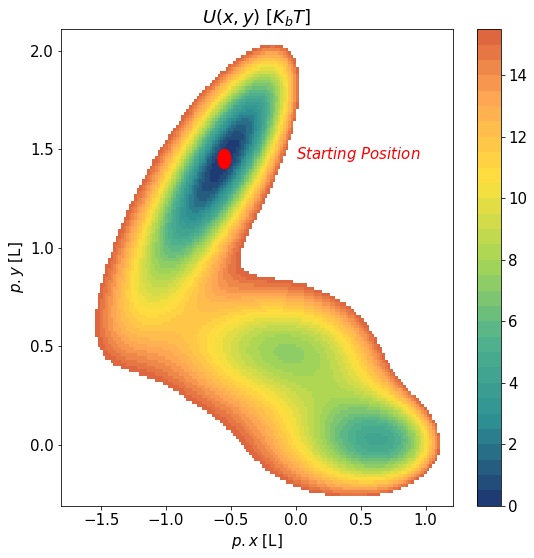

In [3]:
#-- MULLER --#
#-- prepare grid points
y = np.linspace(-0.3,2.1,150)
x = np.linspace(-1.8,1.2,150)
X, Y = np.meshgrid(x, y)
Z = Mullerfunction(X,Y)
#-- set to 0 the lowest basin --#
Z-=np.min(Z)

fig,ax = plt.subplots(figsize=(8,8)) 
#-- color map initialization --#
bounds = np.arange(0, 16, 0.5)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")
c = plt.pcolormesh(X, Y, Z, cmap=cmap,shading='auto',alpha=1,zorder=-1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False)
)
ax.set_xlabel(r"$p.x$ [L]")
ax.set_ylabel(r"$p.y$ [L]")
ax.set_title(r'$U(x,y)$ [$K_b T$]')

#-- highlight the starting point --#
ax.text(0,1.45,r'$Starting$ $Position$',color="red")
draw_circle = plt.Circle((-0.55,1.45), 0.05, color="red")
ax.add_artist(draw_circle)

fig.colorbar(c, ax=ax)
plt.tight_layout()

# Prepare input files for plumed

In [4]:
folder = "unbias/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

# using natural units for Toy Model 
UNITS NATURAL

# compute position for the one particle  
p: POSITION ATOM=1
# adding external potential 
potential: CUSTOM ARG=p.x,p.y FUNC="""+Mullerpot(),""" PERIODIC=NO
ene: BIASVALUE ARG=potential

# Print 
# STRIDE=200 so that the printed time is in 1 ps
PRINT FMT=%g STRIDE=200 FILE=COLVAR ARG=p.x,p.y,ene.bias

ENDPLUMED
""",file=file)

#-- write input files for ves module --#
generate_input_file(name_file=folder+"input",nstep=sim_parameters["nstep"],temp=sim_parameters["temp"],
                    friction=sim_parameters["friction"],random_seed=sim_parameters["plumedseed"],
                    initial_position=sim_parameters["initial_position"])
write_coeff("0",folder+"input")

#-- move necessary files for ves module --#
execute("mv pot_coeffs_input.data unbias",folder=".")
#-- run plumed --#
execute("plumed ves_md_linearexpansion input",folder=folder)

Completed: mv pot_coeffs_input.data unbias
Completed: plumed ves_md_linearexpansion input


## Unbias Trajectory 

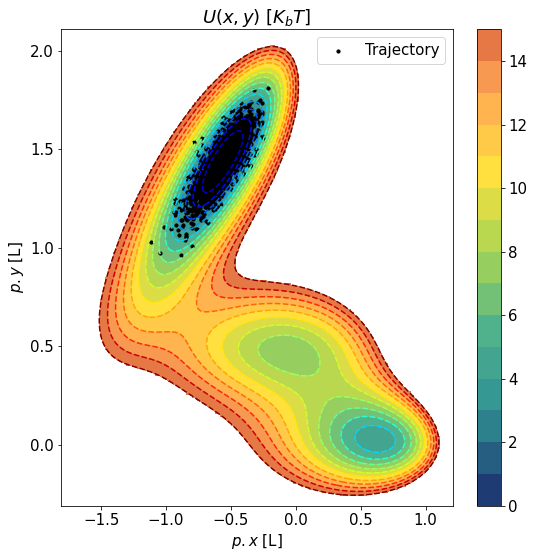

In [5]:
fig, ax = plt.subplots(figsize=(8,8))

x,y = load_dataframe("unbias/COLVAR").filter(regex="^p.x").values,load_dataframe("unbias/COLVAR").filter(regex="^p.y").values
ax.scatter(x,y,color="black",alpha=1,label="Trajectory",s=10)

#-- prepare grid points
y = np.linspace(-0.3,2.1,150)
x = np.linspace(-1.8,1.2,150)
X, Y = np.meshgrid(x, y)
Z = Mullerfunction(X,Y)
#-- set to 0 the lowest basin --#
Z-=np.min(Z)

#bounds = np.arange(np.min(Z), np.max(Z), 5.)
bounds = np.arange(0, 16, 1.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")

c = plt.pcolormesh(X, Y, Z, cmap=cmap,shading='auto',alpha=1,zorder=-1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False)
)
c = plt.contourf(X, Y, Z, bounds , cmap=cmap,shading='auto',alpha=1,zorder=-1, linewidth=10,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="Energu Surface"
)
fig.colorbar(c, ax=ax)
c = plt.contour(X, Y, Z, bounds , cmap="jet",shading='auto',alpha=1, linewidth=5, linestyles="dashed")
#-- if put label on isolines --#
#c.clabel()

ax.legend()
ax.set_xlabel(r"$p.x$ [L]")
ax.set_ylabel(r"$p.y$ [L]")
ax.set_title(r'$U(x,y)$ [$K_b T$]')
plt.tight_layout()

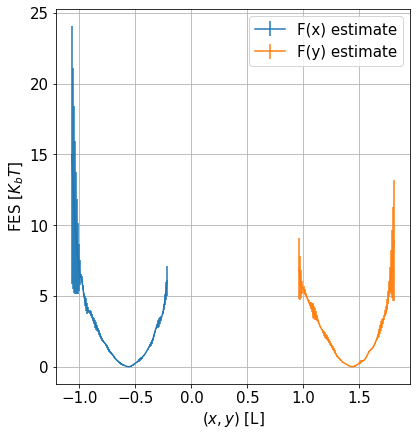

In [6]:
#-- estimation of Free Energy Surface --#
s = load_dataframe("unbias/COLVAR").filter(regex="^p").to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(x) estimate","F(y) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(x,y)$ [L]")
ax.set_ylabel(r"FES [$K_b T$]")

plt.show()

## Unbias simulation DeepTICA Analysis and Export  
  
Before performing the training we have to choose the `lag_time`. How to do that?  

#### How to choose $\tau$ 
The choice of $\tau$ is strictly related to the timescales of the slow modes we are interested in. In addition due to the condition (2), explained in `README.md` file, we do not want overlap between eigenvalues. This mean that choosing either a really small or really large value for $\tau$ it is not a wise choice. Physically speaking choosing a really small value for $\tau$ means that all the slow modes are *slow*, and it becomes difficult to distinguish them. While choosing a very large value for $\tau$ means that all the slow modes are *fast* and their eigenvalues will vanish. In principle every value of $\tau$ in this interval would be good.. but what does it mean *small* and *large*?  
  
One possibility is to look directly at the time auto-correlation function $C(\tau)$ of the descriptors $d_j(\vec x)$, and from it one can estimate their correlation length $\xi$, also called *memory timescale*. When the simulated system is in equilibrium one can expect that the time auto-correlation function decays as an exponential $e^{-\frac{\tau}{\xi}}$. In this case $\xi$ can be estimated by fitting $C(\tau)$. But I will use a more generale definition of $\xi$, which will give us a better estimation: $\xi = \int d \tau C(\tau)$
  
### Time auto-correlation function of the descriptors  

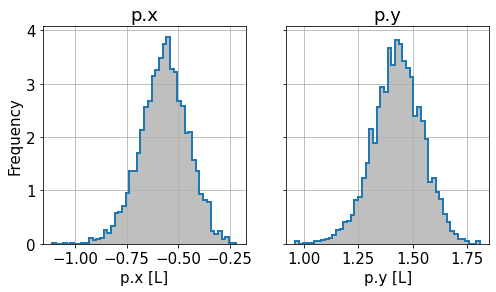

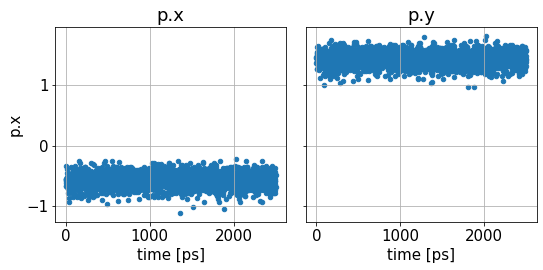

In [7]:
data = load_dataframe("unbias/COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_xlabel(desc + " [L]")
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data.plot.scatter(x="time",y=desc,ax=ax,legend=False,grid=True)
    ax.set_xlabel("time [ps]")
    ax.set_title(desc)


plt.tight_layout()

## Autocorrelation  

$C(k) = \dfrac{\sum_i^{N-k} (Y_i - \bar Y)(Y_{i+k} - \bar Y) }{\sum_i^{N} (Y_i - \bar Y)^2}$  

In [8]:
#-- Unbias Autocorrelation --#
# this implementation is the same as *autocorr* method in pandas
# but with this I can choose if either normalize the result or not
def my_autocorrelation_pandaslike(x,lag,normed=True):
    
    mean = np.average(x,weights=None)
    variance = np.cov(x,aweights=None)
    N = len(x)
      
    x_lag = x[lag::]
    x_0 = x[:(N-lag)]

    if normed:
        autocorr =  np.sum( np.multiply( (x_0-mean), (x_lag-mean) ) ) / ( (N-lag) * variance ) 
    else:
        autocorr = np.sum( np.multiply( x_0, x_lag )) / (N-lag)
    
    return autocorr

In [9]:
#-- My Autocorrelation --#
# with this implementation I recall and use the method implemented in *mlcvs* python package
# more details and benchmark in *Time_Lagged_Dataset* folder
def my_autocorrelation(x,lag,weight=None,time=None,normed=True):
   
    N = len(x)
    if weight is None:
        weight = np.ones(N)
    if time is None:
        time = np.arange(0,N)

    data = create_time_lagged_dataset(x, t = time, lag_time = lag, logweights = np.log(weight))
    x_t,x_lag,w_t,w_lag = np.array(data[:][0]),np.array(data[:][1]),np.array(data[:][2]),np.array(data[:][3])
    Nw = np.sum(w_t)
    mean = np.average(x_t,weights=w_t)
    variance = np.cov(x_t,aweights=w_t)

    if normed:
        autocorr = np.sum( np.multiply( np.multiply( (x_t-mean), (x_lag-mean) ), w_lag ) ) / (Nw*variance)
    else:
        autocorr = np.sum( np.multiply( np.multiply( (x_t), (x_lag) ), w_lag ) ) / Nw

    return autocorr

autocorrelation for  p.x
autocorrelation for  p.y


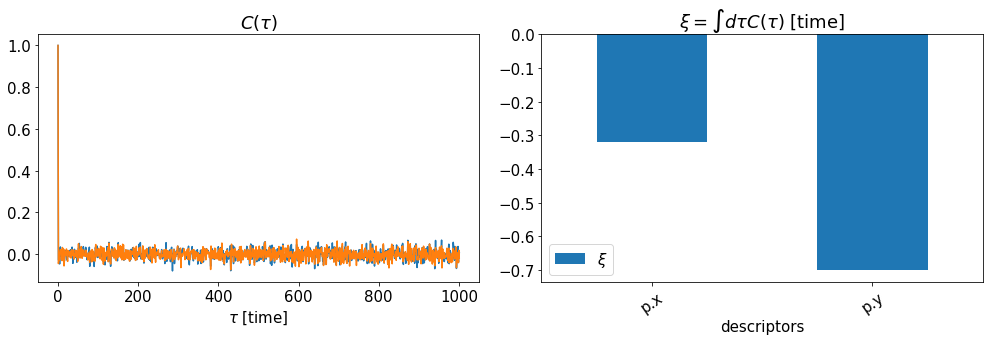

-0.3204807728639977
-0.7012919805905089


In [10]:
data = load_dataframe("unbias/COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(14,5))#,sharey=True)

last=1000
x = np.linspace(0,last+1,last)
acorr = np.empty(last)
timescale = np.empty(len(descriptors_names))
k=0
for desc in descriptors_names:
    print("autocorrelation for ", desc)
    for i in range(last):
        acorr[i] = data[desc].autocorr(i)
    axs[0].plot(x,acorr)
    timescale[k] = integrate.trapz(acorr[:last],x[:last])
    k+=1

times = pd.DataFrame(descriptors_names,columns=["descriptors"])
times["timescale"] = timescale
times.plot(kind="bar",x="descriptors",y="timescale",rot=35,ax=axs[1],fontsize=15,label=r"$\xi$")

axs[0].set_xlabel(r'$\tau$ [time] ')
axs[0].set_title(r'$C(\tau)$')
axs[1].set_title(r'$\xi=\int d\tau C(\tau)$ [time]')

plt.tight_layout()
plt.show()

print(np.max(timescale))
print(np.min(timescale))

# Training Deep-TICA cvs

In [11]:
data = load_dataframe("unbias/COLVAR")
size = len(data)
min_lag,max_lag = 1,5 
n = 5 # how many lag times between min and max lag
lags = np.linspace(min_lag,max_lag,n) #-- how many batches for the train and valid set of a single simulation
print(lags)
shuffle = False # if shuffle the data between batches
#-- train_datasets and valid_datasets list, it will be filled with new data every iteration
train_datasets = []
valid_datasets = []
# torch seed 
torch.manual_seed(21)

descriptors_names = data.filter(regex='^p').columns.values

#-- TRAINING PARAMETERS --#
n_output = 2
n_input = len(descriptors_names)
train_parameters = {
              'descriptors': '^p', # can change during simulation
              'nodes':[n_input,10,n_output],
              'activ_type': 'tanh',#'relu','selu','tanh'
              'lag_time':10, 
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.8, 
              'lrate':1e-4,
              'l2_reg':0.,
              'num_epochs':1000,
              'batchsize': -1, #---> è da fare sul train loder and valid loader
              'es_patience':100,
              'es_consecutive':True,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              }
#--------------------------------------#

# how many data in single batch, batchsize
n_train = int( size*train_parameters["trainsize"] )
n_valid = int( size*(1-train_parameters["trainsize"])-int(10*max_lag) )
print("training samples: ",n_train, "\t validation samples", n_valid)

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = data['time'].values
X = data[descriptors_names].values

[1. 2. 3. 4. 5.]
training samples:  2000 	 validation samples 450


In [12]:
# create time lagged dataset with different lag times
for lag in lags:
    #random split
    # TensorDataset (x_t,x_lag,w_t,w_lag)
    dataset = create_time_lagged_dataset(X,t=t,lag_time=lag,interval=[0,n_train+n_valid])
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_datasets.append(train_data)
    valid_datasets.append(valid_data)

train_loader = FastTensorDataLoader(train_datasets, batch_size=n_train,shuffle=shuffle)
valid_loader = FastTensorDataLoader(valid_datasets, batch_size=n_valid,shuffle=shuffle)

#-- TRAIN --#
# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'],gaussian_random_initialization=True)
model.to(device)
# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])
# lrscheduler
#model.set_LRScheduler(opt,min_lr=5e-5)
model.set_optimizer(opt)
if valid_loader is not None:
    # EarlyStopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.0,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False) 
# TRAIN
model.fit(train_loader=train_loader,valid_loader=valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])
#-- move the model back to cpu for convenience --#
model.to('cpu')

Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.007      -0.019      0.015  0.001  
100   -0.010      -0.024      0.030  -0.003 
150   -0.012      -0.025      0.037  -0.004 
200   -0.013      -0.026      0.042  -0.005 
250   -0.014      -0.027      0.046  -0.006 
300   -0.014      -0.027      0.049  -0.007 
350   -0.015      -0.027      0.051  -0.007 
400   -0.015      -0.027      0.053  -0.007 
INFO: Early stopping
439   -0.016      -0.027      0.054  -0.008 


DeepTICA_CV(
  (nn): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

## DeepTICA Analysis and Export

In [13]:
#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

model saved
torch.float32
timescales:  [3.4278736 2.044458 ]
eigenvalues:  [ 0.05408164 -0.00751186]


## Load existing model  
  
It is possible to load an existing model  

```py
data = load_dataframe(folder+"COLVAR")
search_values="^p."
X, t, logweight = data.filter(regex=search_values).values, data['time'].to_numpy(). data["opes.bias"].to_numpy()

logweight = ( logweight-max(logweight) ) / sim_parameters["temp"]

model = DeepTICA_CV(train_parameters["nodes"],activation=train_parameters['activ_type'])
model.load_checkpoint(folder+"deeptica/model_checkpoint.pt")
```

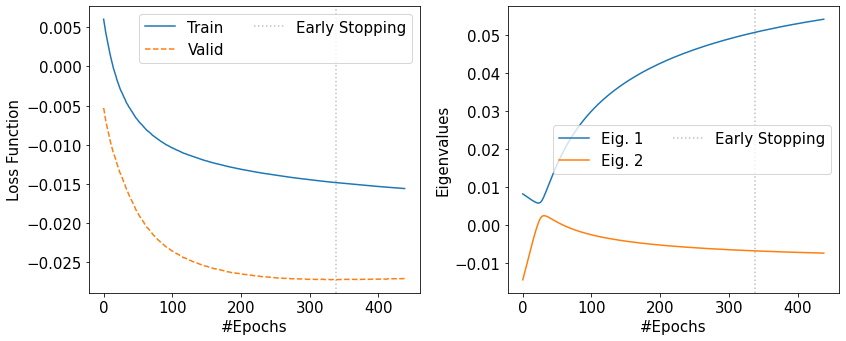

In [14]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [15]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

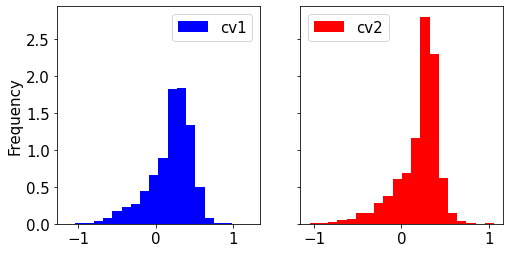

In [16]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

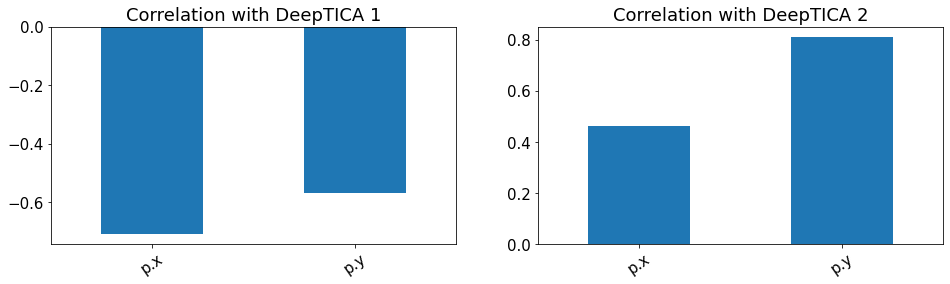

In [17]:
fig,axs = plt.subplots(1,2,figsize=(16,4))
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex='^p.').columns)
    corr = data[cols].corr(method='pearson')

    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35)
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

### FES estimate from cvs  
Obviously from this first simulation it is not possible to found a cvs that from data are able to distinguish all the possible basins. I recall that our approach is a **data drive approach**.  


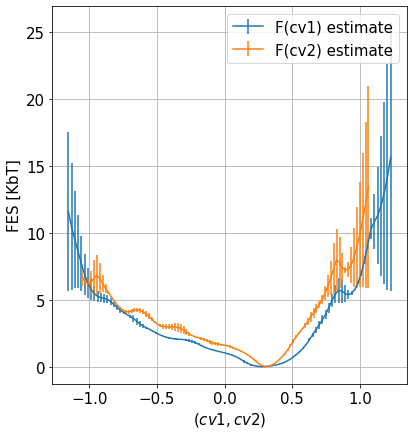

In [18]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")

plt.show()

### Isolines  
We are working with a two dimensional Potential, and we are using as descriptors the two cartesian coordinates. This allows us to plot the isolines of the cvs on the physical space $(x,y)$    

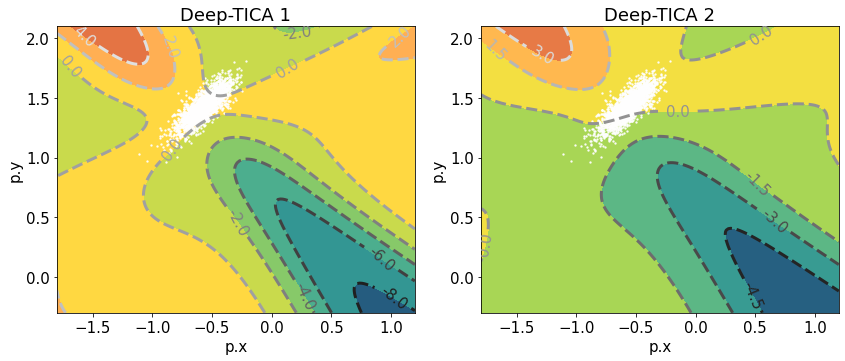

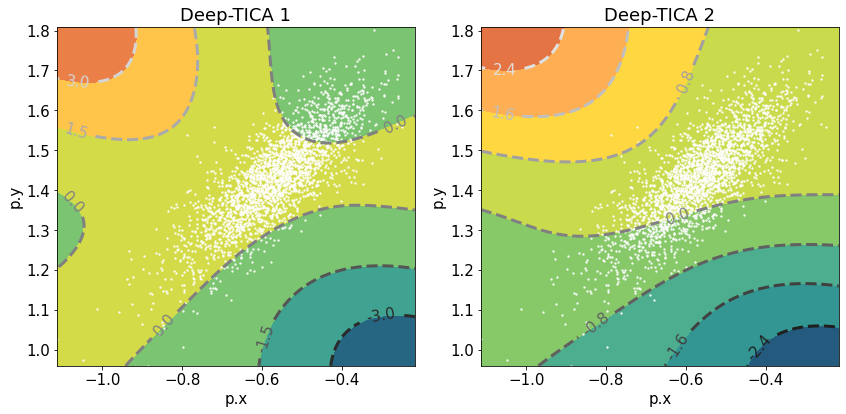

In [19]:
plot_cvs_isolines(model,limits=((-1.8,1.2),(-0.3,2.1)),scatter=X)
lim = ((np.min(X[:,0]),np.max(X[:,0])),(np.min(X[:,1]),np.max(X[:,1])))
plot_cvs_isolines(model,limits=lim,scatter=X)

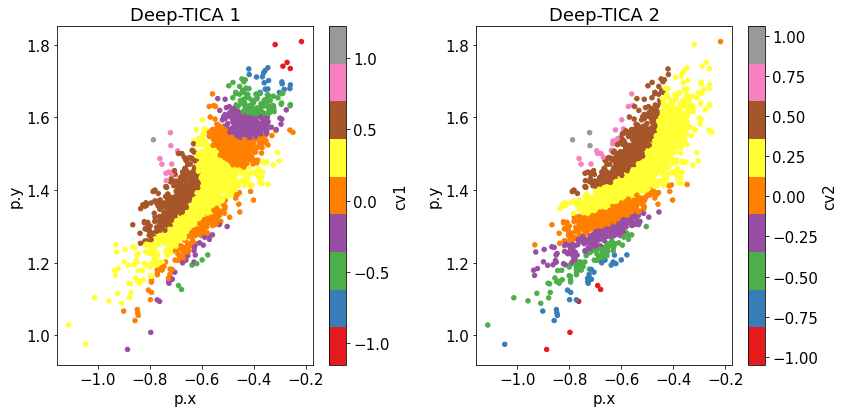

In [20]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="p.y",x="p.x",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

# TICA

In [34]:
# MODEL
tica = TICA_CV(n_features=X.shape[1])
tica.to(device)

t = data['time'].values
X = data[descriptors_names].values

In [35]:
# TRAIN
tica.fit(X, t, lag=min_lag)

#-- move the model back to cpu for convenience --# 
tica.to('cpu')
feature_names = data.filter(regex="p.*").columns.values
tica.set_params({"feature_names": feature_names})
#-- print some useful results --#
#print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",tica.tica.evals_.detach().cpu().numpy())

eigenvalues:  [ 0.00086393 -0.04490364]


In [36]:
data["cv1_tica"] = np.transpose(tica(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2_tica"] = np.transpose(tica(torch.Tensor(X)).detach().cpu().numpy())[1] 

<AxesSubplot:ylabel='Frequency'>

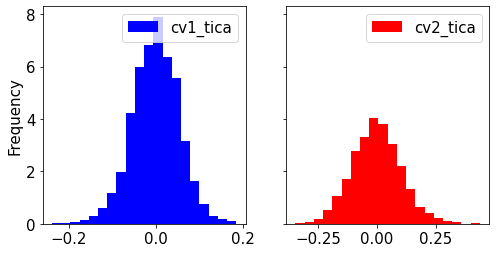

In [37]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1_tica",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2_tica",bins=20,ax=axs[1],density=True,color="r")

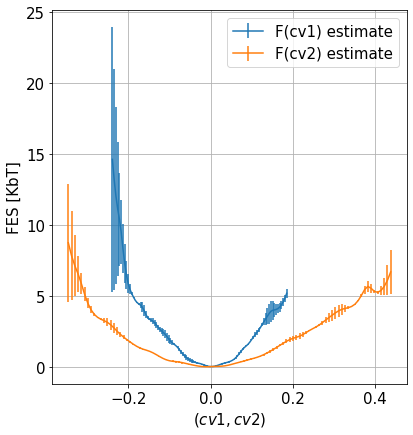

In [38]:
#-- estimation of Free Energy Surface --#
s = data[["cv1_tica","cv2_tica"]].to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")

plt.show()

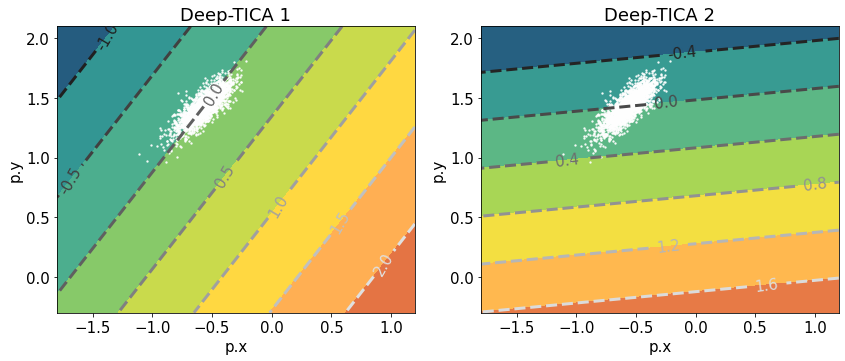

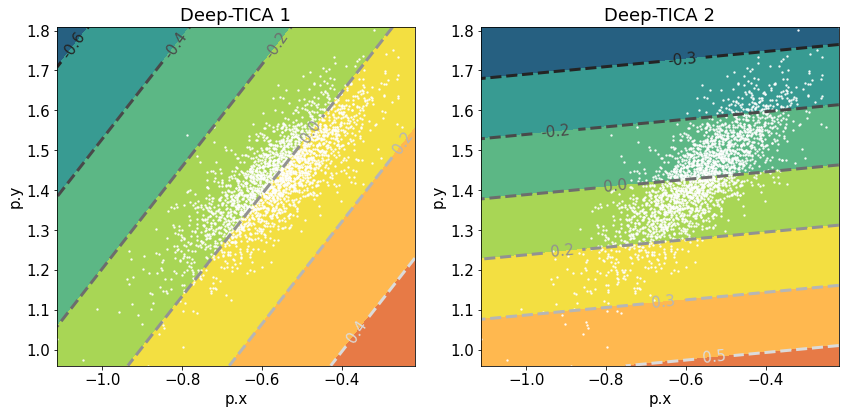

In [39]:
plot_cvs_isolines(tica,limits=((-1.8,1.2),(-0.3,2.1)),scatter=X)
lim = ((np.min(X[:,0]),np.max(X[:,0])),(np.min(X[:,1]),np.max(X[:,1])))
plot_cvs_isolines(tica,limits=lim,scatter=X)

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [40]:
Boltzmann_product(model,model,X,j=0,k=1)

0.03936525287508924

This results reflects the fact that we have enforce the symmetrization of $C(\tau)$  
then one can enforce the orthogonality on the data

In [41]:
#-- check scalar product --#
#DeepTICA 1
cv1 = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
#DeepTICA 2 orthogonal to DeepTICA 1
new_cv2 = orthogonal_cv(model,X)
prod = np.multiply(np.multiply(cv1,np.ones(X.shape[0])),new_cv2).mean()
print(prod)

-8.004171358986257e-10


Text(0.5, 1.0, 'Deep-TICA 2 orthogonal')

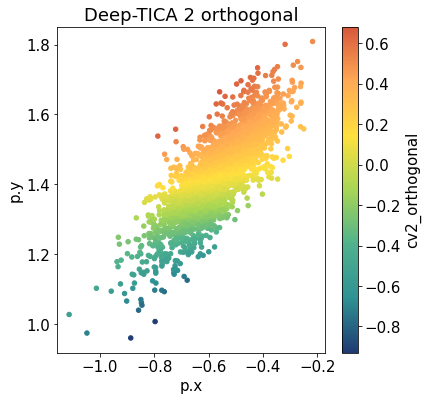

In [42]:
data["cv2_orthogonal"] = new_cv2
fig,ax = plt.subplots(1,1,figsize=(6,6))
data.plot.scatter(y="p.y",x="p.x",c="cv2_orthogonal",cmap="fessa",ax=ax)
ax.set_title('Deep-TICA 2 orthogonal')

# Prepare the next simulation input files using TICA rather than Deeptica
### Plumed

In [43]:
folder = "unbias/bias1_tica/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

# using natural units for Toy Model 
UNITS NATURAL

# compute position for the one particle  
p: POSITION ATOM=1
# adding external potential 
potential: CUSTOM ARG=p.x,p.y FUNC="""+Mullerpot(),"""PERIODIC=NO
ene: BIASVALUE ARG=potential

# define cv
tica_cv1_0"""+
tica.plumed_input().splitlines()[0][8:]+"""\ntica_cv2_0"""+tica.plumed_input().splitlines()[1][8:]
+"""
# bias 
opes: OPES_METAD ARG=tica_cv1_0 TEMP="""+str(sim_parameters["temp"])+""" PACE=500 FILE=KERNELS BIASFACTOR=1.8 RESTART=NO BARRIER=7 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10
 
PRINT FMT=%g STRIDE=200 FILE=COLVAR ARG=tica_cv1_0,tica_cv2_0,p.x,p.y,ene.bias,opes.*

ENDPLUMED
""",file=file)